# I523: Fall17 - Final Project
###   By HID333;HID337

## IoT and Big Data Analytics for Equipment Predictive Health Management (PHM)
### Project Description:
    The predictive health management (PHM) is an enabling discipline
    consisting of technologies and methods to assess the reliability of a
    product in its actual life cycle conditions to determine the advent
    of failure and mitigate system risk. The PHM system will monitor
    environmental, operational, and performance related characteristics
    of the product and gathered data analyzed to assess product health
    and predict remaining life.
    In this application, the industrial rotating equipment such as
    compressors, vacuum blowers, pumps, and valves etc. are considered
    to monitor and analyze their operational behavior. The product
    critical operational parameter data such as vibration, temperature,
    and load current will be collected from field sensors and analyzed
    to predict the failure using kNN machine learning classification
    algorithms. The data will be collected from the field using wireless
    sensors and stored on the cloud based AWS database server. The
    product data will be analyzed and made available to all stake holders
    to take appropriate preventive actions via web/mobile applications.

## Overview
* Read Equipment Sensor Training Data from ORACLE DB tables
* Build KNN Classifier 
  * Find best K value for KNN
  * Build KNN model using Equipment Sensor Training Data
  * Find the accurancy of the Model
* Read Sensor Data which needs to be classified using KNN
* Run Predictions on the Test Sensor Data
* Update the results back in the Oracle DB
* Run Analytics on the updated results
* Repeat above steps for Equipment2 and Equipment3
* Draw Results

### Step 1: Read Training Data from Amazon RDS (Oracle DB)

In [360]:
#import regular python and oracle libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle


#import oracle library
import cx_Oracle

#Get amazon RDS oracle test db connection to read Training and Test Data
connection = cx_Oracle.connect('tdmaster/telidos2015@tdmetadata.ckevkzrwi1v2.us-west-2.rds.amazonaws.com:1521/orcl')
cursor = connection.cursor()

#define sql statements to select data for each equipment
eqp1SQL="SELECT INT_AMB_TEMP,EXT_AMB_TEMP,INPUT_CUR,INPUT_VOLT,VIB_X_AXIS,VIB_Y_AXIS,VIB_Z_AXIS,LABEL,LABEL_INT FROM SENSOR_TRAIN_DATA_V WHERE UPPER(EQP_NAME)=UPPER('Vacuum Blower')"
eqp2SQL="SELECT INT_AMB_TEMP,EXT_AMB_TEMP,INPUT_CUR,INPUT_VOLT,VIB_X_AXIS,VIB_Y_AXIS,VIB_Z_AXIS,LABEL FROM SENSOR_TRAIN_DATA WHERE UPPER(EQP_NAME)=UPPER('Smart Valve')"
eqp3SQL="SELECT INT_AMB_TEMP,EXT_AMB_TEMP,INPUT_CUR,INPUT_VOLT,VIB_X_AXIS,VIB_Y_AXIS,VIB_Z_AXIS,LABEL FROM SENSOR_TRAIN_DATA WHERE UPPER(EQP_NAME)=UPPER('Air Compressor')"


### Step 2: Build KNN Classifier

In [361]:
#Though Equipments are using same features, but noramal operation parameters are varying for each equipment.
#One Model trained for one equipment cannot be used to predicit health of another equipment. 
#Since we are supporting 3 equipments, building 3 KNN models one for each equipment.

#Build EQP1 Model: Vacuum Blower
cursor.execute(eqp1SQL)
eqp1SQLResult = cursor.fetchall() 
eqp1List = [list(i) for i in eqp1SQLResult]
eqp1TrainArray = np.asarray(eqp1List)
# Split-out validation dataset for EQP1
x1 = eqp1TrainArray[:,0:7]
y1 = eqp1TrainArray[:,7]
#random_state can be any number. This is to replicate results over multiple runs
x1_train, x1_validation, y1_train, y1_validation = model_selection.train_test_split(x1, y1, test_size=.2, random_state=7)


#### View first fiew rows

In [362]:
#describe data first few rows
df = pd.DataFrame(eqp1SQLResult,columns = ['INT_AMB_TEMP','EXT_AMB_TEMP','INPUT_CUR','INPUT_VOLT','VIB_X_AXIS','VIB_Y_AXIS','VIB_Z_AXIS','LABEL','LABEL_INT'])
# Shuffle training data
df = shuffle(df)
print(df.head())
#end describe data

       INT_AMB_TEMP  EXT_AMB_TEMP  INPUT_CUR  INPUT_VOLT  VIB_X_AXIS  \
12666         40.00          30.0       12.0     114.905    2.696955   
11720         40.00          45.0       12.0     122.905    2.696955   
18461         84.47          30.0       12.0     115.000    2.696955   
7307          40.00          30.0       20.0     107.000    2.696955   
20205         40.00          30.0       12.0     139.305    2.696955   

       VIB_Y_AXIS  VIB_Z_AXIS                     LABEL  LABEL_INT  
12666   -0.894902   -3.533973        NORMAL_OP_30_DEG_C          1  
11720   -0.894902   -3.533973      ABNORMAL_OP_30_DEG_C          5  
18461   -0.894902   -3.533973        OVER_TEMP_FAULT_OP          3  
7307    -0.894902   -3.533973     OVER_CURRENT_FAULT_OP          2  
20205   -0.894902   -3.533973  INPUT_OVER_VOLT_FAULT_OP          4  


#### View last few rows

In [363]:
print(df.tail())

       INT_AMB_TEMP  EXT_AMB_TEMP  INPUT_CUR  INPUT_VOLT  VIB_X_AXIS  \
14504         40.00          30.0     11.616     115.000    2.696955   
4444          90.00          30.0     12.000     119.105    2.696955   
3435          38.28          30.0     12.000     135.000    2.696955   
8339          40.00          30.0     12.000     119.595    2.696955   
17356         90.00          30.0     11.920     115.000    2.696955   

       VIB_Y_AXIS  VIB_Z_AXIS                     LABEL  LABEL_INT  
14504   -0.894902   -3.533973        NORMAL_OP_30_DEG_C          1  
4444    -0.894902   -3.533973        OVER_TEMP_FAULT_OP          3  
3435    -0.894902   -3.533973  INPUT_OVER_VOLT_FAULT_OP          4  
8339    -0.894902   -3.533973        NORMAL_OP_30_DEG_C          1  
17356   -0.894902   -3.533973        OVER_TEMP_FAULT_OP          3  


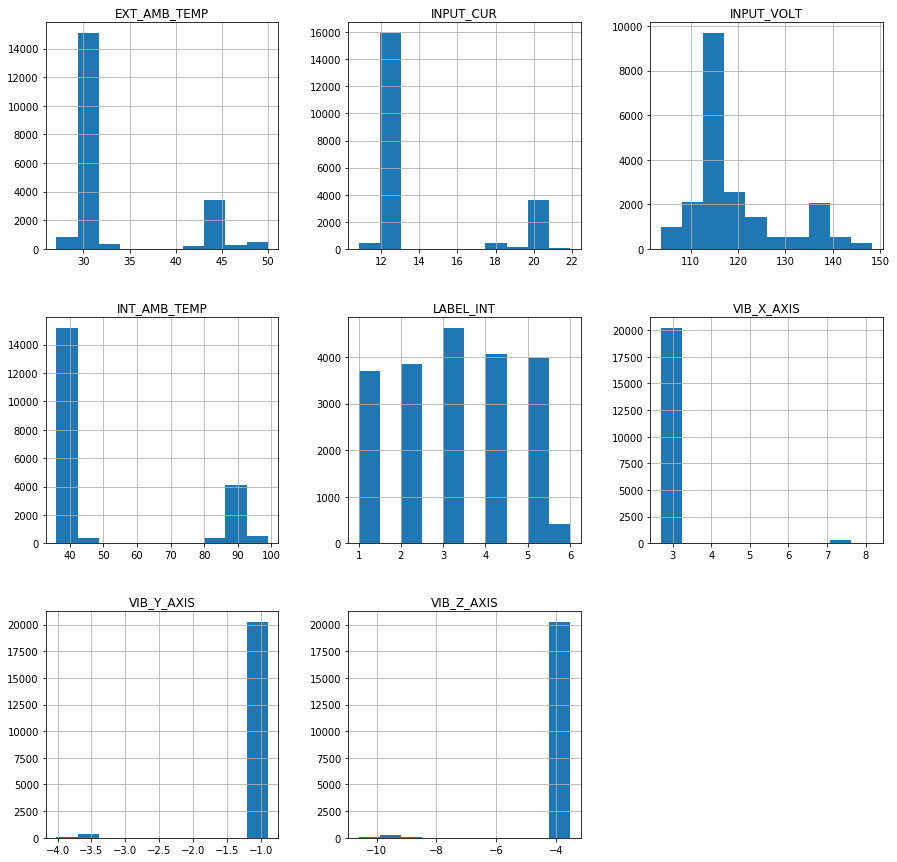

In [364]:
# plot training data features
df.hist(figsize=[15,15])
plt.show()

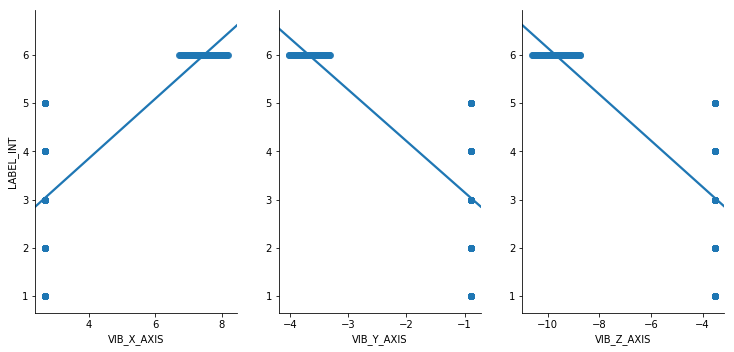

In [365]:
import seaborn as sns

# print plots within the notebook
%matplotlib inline

sns.pairplot(df, x_vars=['VIB_X_AXIS','VIB_Y_AXIS','VIB_Z_AXIS'], y_vars='LABEL_INT', size=5, aspect=0.7, kind='reg')

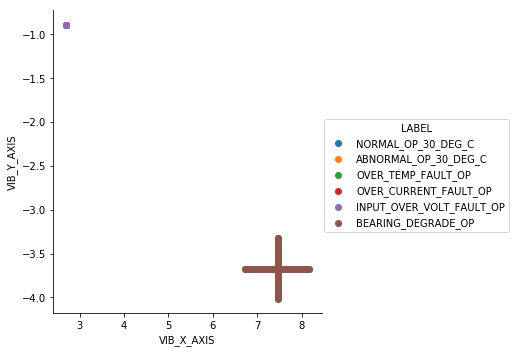

In [366]:
sns.FacetGrid(df, hue = "LABEL", size =5).map(plt.scatter, "VIB_X_AXIS", "VIB_Y_AXIS").add_legend()

#### Find best value of K

In [367]:
# find best value of K for KNN model
k_range = list(range(1, 10))
# list different accuracy scores.
k_scores = []

for k in k_range:
    # use 10-fold cross validation
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn,x1, y1, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())

# get best k
best_k = k_range[k_scores.index(max(k_scores))]
print ("The best value for K is %d" % best_k)

# build KNN with best K
eqp1KNN = KNeighborsClassifier(n_neighbors=best_k)
eqp1KNN.fit(x1_train, y1_train)

The best value for K is 8


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='uniform')

#### Find Accuracy of the Model

In [368]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
cv_results = model_selection.cross_val_score(eqp1KNN, x1_train, y1_train, cv=kfold, scoring='accuracy')
print(cv_results)
print(cv_results.mean())

[ 0.99212598  0.98485766  0.98788613  0.99212598  0.9909146   0.98909752
  0.9903089   0.98970321  0.98728044  0.9903089 ]
0.989460932768


### Step 3: Read Sensor Data (Test Data) from Amazon Oracle DB that needs to be Classified using KNN

In [369]:
# Read equipment1 sensor data that need to be classified
# select statemet to query equipment1 sensor data
eqp1TestDataSQL="SELECT RECORD_ID,INT_AMB_TEMP,EXT_AMB_TEMP,INPUT_CUR,INPUT_VOLT,VIB_X_AXIS,VIB_Y_AXIS,VIB_Z_AXIS FROM SENSOR_TEST_DATA WHERE UPPER(EQP_NAME)=UPPER('Vacuum Blower') "
cursor.execute(eqp1TestDataSQL)
eqp1SqlTestData = cursor.fetchall() 
eqp1TestDataList = [list(j) for j in eqp1SqlTestData]
eqp1TestDatatArray = np.asarray(eqp1TestDataList)


### Step 4: Predict the labels

In [370]:
eqp1UnknownLabels = eqp1TestDatatArray[:,1:8]
ids = eqp1TestDatatArray[:,0]
predictions = eqp1KNN.predict(eqp1UnknownLabels)

### Step 5: Update the results back to the Amazon DB

In [371]:
resultLabelsParam = cursor.arrayvar(cx_Oracle.STRING, predictions.tolist())
idsParam = cursor.arrayvar(cx_Oracle.NUMBER, ids.tolist())
args = [idsParam,resultLabelsParam]
# call pl/sql procedure which updates Sensor table data with predictions
cursor.callproc("BIG_DATA_503_PRJ_PKG.update_testdata_labels", args)
cursor.close()

### Step 6: Repeat above steps for Equipment2 

In [372]:
#Get Equipment2: Smart Valve Data
cursor = connection.cursor()
cursor.execute(eqp2SQL)
eqp2SQLResult = cursor.fetchall() 
eqp2List = [list(i) for i in eqp2SQLResult]
eqp2TrainArray = np.asarray(eqp2List)
# Split-out validation dataset for EQP2
x2 = eqp2TrainArray[:,0:7]
y2 = eqp2TrainArray[:,7]
x2_train, x2_validation, y2_train, y2_validation = model_selection.train_test_split(x2, y2, test_size=.2, random_state=7)
eqp2KNN = KNeighborsClassifier(n_neighbors=best_k)
eqp2KNN.fit(x2_train, y2_train)
# Read equipment2 sensor data that need to be classified
# select statemet to query equipment1 sensor data
eqp2TestDataSQL="SELECT RECORD_ID,INT_AMB_TEMP,EXT_AMB_TEMP,INPUT_CUR,INPUT_VOLT,VIB_X_AXIS,VIB_Y_AXIS,VIB_Z_AXIS FROM SENSOR_TEST_DATA WHERE UPPER(EQP_NAME)=UPPER('Smart Valve') "
cursor.execute(eqp2TestDataSQL)
eqp2SqlTestData = cursor.fetchall() 
eqp2TestDataList = [list(j) for j in eqp2SqlTestData]
eqp2TestDatatArray = np.asarray(eqp2TestDataList)
eqp2UnknownLabels = eqp2TestDatatArray[:,1:8]
ids = eqp2TestDatatArray[:,0]
# predict the result labels
predictions = eqp2KNN.predict(eqp2UnknownLabels)
resultLabelsParam = cursor.arrayvar(cx_Oracle.STRING, predictions.tolist())
idsParam = cursor.arrayvar(cx_Oracle.NUMBER, ids.tolist())
args = [idsParam,resultLabelsParam]
# call pl/sql procedure which updates Sensor table data with predictions
cursor.callproc("BIG_DATA_503_PRJ_PKG.update_testdata_labels", args)
cursor.close()

### Step 7: Repeat above steps for Equipment3

In [373]:
#Get Equipment3:Air Compressor Data
cursor = connection.cursor()
cursor.execute(eqp3SQL)
eqp3SQLResult = cursor.fetchall() 
eqp3List = [list(i) for i in eqp3SQLResult]
eqp3TrainArray = np.asarray(eqp3List)
# Split-out validation dataset for EQP2
x3 = eqp3TrainArray[:,0:7]
y3 = eqp3TrainArray[:,7]
x3_train, x3_validation, y3_train, y3_validation = model_selection.train_test_split(x3, y3, test_size=.2, random_state=7)
eqp3KNN = KNeighborsClassifier(n_neighbors=best_k)
eqp3KNN.fit(x3_train, y3_train)
# Read equipment3 sensor data that need to be classified
# select statemet to query equipment1 sensor data
eqp3TestDataSQL="SELECT RECORD_ID,INT_AMB_TEMP,EXT_AMB_TEMP,INPUT_CUR,INPUT_VOLT,VIB_X_AXIS,VIB_Y_AXIS,VIB_Z_AXIS FROM SENSOR_TEST_DATA WHERE UPPER(EQP_NAME)=UPPER('Air Compressor') "
cursor.execute(eqp3TestDataSQL)
eqp3SqlTestData = cursor.fetchall() 
eqp3TestDataList = [list(j) for j in eqp3SqlTestData]
eqp3TestDatatArray = np.asarray(eqp3TestDataList)
eqp3UnknownLabels = eqp3TestDatatArray[:,1:8]
ids = eqp3TestDatatArray[:,0]
# predict the result labels
predictions = eqp3KNN.predict(eqp2UnknownLabels)
resultLabelsParam = cursor.arrayvar(cx_Oracle.STRING, predictions.tolist())
idsParam = cursor.arrayvar(cx_Oracle.NUMBER, ids.tolist())
args = [idsParam,resultLabelsParam]
# call pl/sql procedure which updates Sensor table data with predictions
cursor.callproc("BIG_DATA_503_PRJ_PKG.update_testdata_labels", args)
# close oracle connections
cursor.close()

### Step 8: Visualize final Results

In [374]:
def plotSerials(resultSQL,title):
    cursor = connection.cursor()
    cursor.execute(resultSQL)
    resultData = cursor.fetchall() 
    resultDataList = [list(j) for j in resultData]
    resultDataArray = np.asarray(resultDataList)
    dfResult = pd.DataFrame(resultData,columns = ['SERIAL_NUMBER','LABEL_COUNT'])

    import matplotlib.ticker as ticker
    toplotx = resultDataArray[:,0]
    toploty = resultDataArray[:,1]
    toploty = np.asfarray(toploty,float)
    ax = plt.axes()
    y_pos = np.arange(len(toplotx))
    plt.bar(y_pos, toploty, align='center', alpha=0.5)
    plt.xticks(y_pos, toplotx)
    plt.ylabel('Label Count')
    plt.title(title)

    plt.show()
    cursor.close()
    return

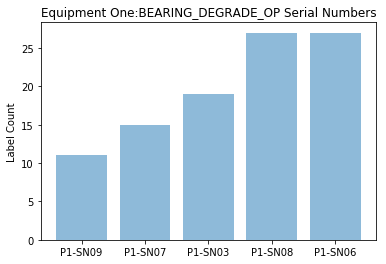

In [375]:
# Display BEARING_DEGRADE_OP Serials
resultBGSQL="SELECT SERIAL_NUMBER,COUNT(LABEL) LABEL_COUNT FROM SENSOR_TEST_DATA_V WHERE LABEL = 'BEARING_DEGRADE_OP' AND EQP_NAME= 'VACUUM BLOWER' group by EQP_NAME,SERIAL_NUMBER,LABEL ORDER BY 2"
plotSerials(resultBGSQL,'Equipment One:BEARING_DEGRADE_OP Serial Numbers')



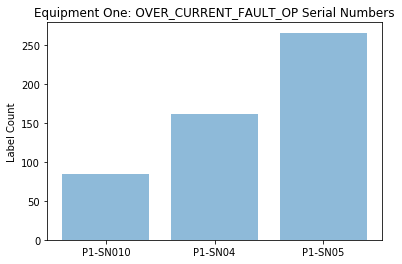

In [376]:
# Display OVER_CURRENT_FAULT_OP Serials
resultOCSQL="SELECT SERIAL_NUMBER,COUNT(LABEL) LABEL_COUNT FROM SENSOR_TEST_DATA_V WHERE LABEL = 'OVER_CURRENT_FAULT_OP' AND EQP_NAME= 'VACUUM BLOWER' group by EQP_NAME,SERIAL_NUMBER,LABEL ORDER BY 2"
plotSerials(resultOCSQL,'Equipment One: OVER_CURRENT_FAULT_OP Serial Numbers')

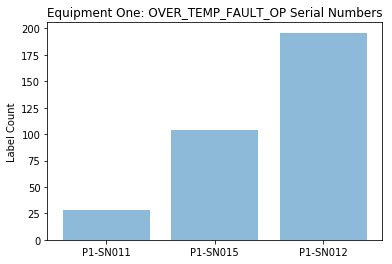

In [377]:
# Display OVER_TEMP_FAULT_OP Serials
resultOTSQL="SELECT SERIAL_NUMBER,COUNT(LABEL) LABEL_COUNT FROM SENSOR_TEST_DATA_V WHERE LABEL = 'OVER_TEMP_FAULT_OP' AND EQP_NAME= 'VACUUM BLOWER' group by EQP_NAME,SERIAL_NUMBER,LABEL ORDER BY 2"
plotSerials(resultOTSQL,'Equipment One: OVER_TEMP_FAULT_OP Serial Numbers')

In [378]:
# Close SQL connectoins
connection.close()
print('Done')

Done
